In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os

In [2]:
data_dir = '/nfs/turbo/si-juliame/metaphor/results/full_datasheets/2024-10-07/'
res_dir = '/nfs/turbo/si-juliame/metaphor/results/regression_feb2025/'
plots_dir = '/home/juliame/metaphor/results/plots_feb2025/'
tables_dir = '/home/juliame/metaphor/results/tables_feb2025/'

if not os.path.exists(plots_dir):
    os.mkdir(plots_dir)
if not os.path.exists(tables_dir):
    os.mkdir(tables_dir)

In [3]:
ig_frames =["Capacity.and.Resources","Crime.and.Punishment","Cultural.Identity","Economic",
"External.Regulation.and.Reputation","Fairness.and.Equality","Health.and.Safety","Legality..Constitutionality..Jurisdiction",
"Morality.and.Ethics", "Policy.Prescription.and.Evaluation","Political.Factors.and.Implications","Public.Sentiment",
"Quality.of.Life","Security.and.Defense"]                    

controls = ['has_hashtag','has_mention','has_url','is_quote_status','is_reply','is_quote_status',
                    'is_verified','log_chars','log_followers','log_following','log_statuses',
                    'year','month','date','(Intercept)']

frame_dict = {}
frame_dict['Capacity.and.Resources'] = "Resources"
frame_dict['Crime.and.Punishment'] = "Crime"
frame_dict['Cultural.Identity'] = "Cultural"
frame_dict['Economic'] = 'Economic'
frame_dict['External.Regulation.and.Reputation'] = 'External'
frame_dict['Fairness.and.Equality'] = "Fairness"
frame_dict['Health.and.Safety'] = "Health & Safety"
frame_dict['Legality..Constitutionality..Jurisdiction'] = "Legality"
frame_dict["Morality.and.Ethics"] = "Morality"
frame_dict["Policy.Prescription.and.Evaluation"] = "Policy"
frame_dict['Political.Factors.and.Implications'] = "Political Factors"
frame_dict['Public.Sentiment'] = "Public Sentiment"
frame_dict['Quality.of.Life'] = "Quality of Life"
frame_dict['Security.and.Defense'] = "Security & Defense"

In [4]:
def replace_frame_terms(df,frame_dict):
    df['term'] = [x[:-1] if x.endswith('1') else x for x in df['term']]
    interaction_dict = {f'ideology:{k}':f'ideology:{v}' for (k,v) in frame_dict.items()}
    df['term'] = df['term'].replace(frame_dict)
    df['term'] = df['term'].replace(interaction_dict)
    return df


In [5]:
FRAME_PREFIX = 'frames' # no_frames or frames ("frames" are results that additionally control for issue-generic frames)
DATE = '2024-10-07' # just part of the file string

# Get original dataframes to calculate original means 
df_orig = pd.read_csv(os.path.join(data_dir,'filtered_tweet_data_shuffled_no_text_results_with_scores.tsv'),sep='\t')

# Load regression results (df_reg has coefficients, df_mfx and df_mfx_group have marginal effects
file_prefix = f'ideology_effects_on_metaphor_{DATE}_{FRAME_PREFIX}_score_binarized_ideology'
df_reg = pd.read_csv(os.path.join(res_dir,f'{file_prefix}_regression_results.tsv'),sep='\t')
df_mfx = pd.read_csv(os.path.join(res_dir,f'{file_prefix}_avg_marginal_effects.tsv'),sep='\t')
df_mfx_group = pd.read_csv(os.path.join(res_dir,f'{file_prefix}_marginal_effects_by_ideology.tsv'),sep='\t')

# Replace issue-generic frame terms from regression output
df_reg = replace_frame_terms(df_reg,frame_dict)
df_mfx = replace_frame_terms(df_mfx,frame_dict)
df_mfx_group = replace_frame_terms(df_mfx_group,frame_dict)


# Filter out control variables to get only ideology-related effects for visualization
df_mfx_id = df_mfx[df_mfx['term']=='ideology'].sort_values(by='estimate',ascending=False)
df_mfx_id = df_mfx_id[df_mfx_id['concept'] != 'overall'] # Omit domain-agnostic results

df_mfx_mag = df_mfx_group[df_mfx_group['term']=='magnitude']
df_mfx_mag = df_mfx_mag[df_mfx_mag['concept'] != 'overall'] # Omit domain-agnostic results

In [6]:
# Create df_mean_scores: Average metaphor score per (binary) ideology per concept
concepts = ['animal','vermin','parasite','war','pressure','water','commodity']
orig_cols = ['score_' + concept for concept in concepts]
df_orig_sub = df_orig[['ideology'] + orig_cols]
df_orig_sub['ideology'] = df_orig_sub['ideology'].apply(lambda x: 1 if x > 0 else 0)
df_orig_sub.columns = [col.replace('score_','') for col in df_orig_sub.columns]
df_orig_sub = pd.melt(df_orig_sub,id_vars=['ideology'],var_name='concept',value_name='score')
df_mean_scores = df_orig_sub[['ideology','concept','score']].groupby(by=['ideology','concept']).agg('mean').reset_index()


/tmp/ipykernel_3579917/494046022.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_orig_sub['ideology'] = df_orig_sub['ideology'].apply(lambda x: 1 if x > 0 else 0)


In [135]:
def get_percent_change(df,effect_col,error_col,metaphor_score_col):
    df['percent_change'] = 100 * df[effect_col] / df[metaphor_score_col]
    df['percent_change_se'] = 100 * df[error_col] / df[metaphor_score_col]
    return df

In [136]:
# Add Liberal mean scores as baseline for percent change
df_mfx_id = df_mfx_id.merge(df_mean_scores[df_mean_scores['ideology']==0],on='concept')

# Calculate percent change in metaphor scores with conservative ideology (liberal as baseline)
df_mfx_id = get_percent_change(df_mfx_id,'estimate','std.error','score')

In [137]:
df_mfx_id

,term,contrast,estimate,std.error,statistic,p.value,s.value,conf.low,conf.high,concept,p.corrected,ideology,score,percent_change,percent_change_se
0,ideology,1 - 0,0.012697,0.000269,47.264578,0.000000e+00,inf,0.012170,0.013223,water,0.000000e+00,0,0.094222,13.475515,0.285108
1,ideology,1 - 0,0.011102,0.000386,28.743986,1.076934e-181,601.162056,0.010345,0.011859,war,2.153867e-181,0,0.106147,10.459307,0.363878
2,ideology,1 - 0,0.009361,0.000239,39.241649,0.000000e+00,inf,0.008894,0.009829,pressure,0.000000e+00,0,0.080975,11.560569,0.294599
3,ideology,1 - 0,0.008971,0.000261,34.309124,5.736880e-258,854.537182,0.008459,0.009484,animal,1.721064e-257,0,0.113962,7.872252,0.229451
4,ideology,1 - 0,0.008516,0.000189,45.170849,0.000000e+00,inf,0.008147,0.008886,parasite,0.000000e+00,0,0.072638,11.724601,0.259561
5,ideology,1 - 0,0.008044,0.000304,26.503014,8.947226e-155,511.737414,0.007449,0.008639,commodity,8.947226e-155,0,0.083797,9.599803,0.362216
6,ideology,1 - 0,0.007005,0.000181,38.668654,0.000000e+00,inf,0.006650,0.007360,vermin,0.000000e+00,0,0.076868,9.113439,0.235680


In [138]:
# Get mean scores for liberals and conservatives (ideology strength was standardized so relative to mean for each group)
df_mfx_mag = df_mfx_mag.merge(df_mean_scores,on=['concept','ideology'])
df_mfx_mag = get_percent_change(df_mfx_mag,'estimate','std.error','score')
df_mfx_mag['ideology'] = df_mfx_mag['ideology'].replace({0:'Liberal',1:'Conservative'})
df_mfx_mag

,term,ideology,estimate,std.error,statistic,p.value,s.value,conf.low,conf.high,concept,score,percent_change,percent_change_se
0,magnitude,Liberal,0.000469,0.000331,1.417366,1.563761e-01,2.676908,-0.000180,0.001118,animal,0.113962,0.411885,0.290599
1,magnitude,Conservative,0.002667,0.000135,19.795492,3.255596e-87,287.304823,0.002403,0.002931,animal,0.126483,2.108530,0.106516
2,magnitude,Liberal,-0.001211,0.000384,-3.150793,1.628278e-03,9.262437,-0.001965,-0.000458,commodity,0.083797,-1.445409,0.458745
3,magnitude,Conservative,0.001364,0.000156,8.719978,2.782565e-18,58.318290,0.001057,0.001670,commodity,0.094676,1.440363,0.165180
4,magnitude,Liberal,0.000757,0.000239,3.170013,1.524323e-03,9.357616,0.000289,0.001225,parasite,0.072638,1.042241,0.328781
5,magnitude,Conservative,0.002623,0.000097,27.002307,1.388521e-160,531.034946,0.002433,0.002813,parasite,0.082184,3.191641,0.118199
6,magnitude,Liberal,-0.000019,0.000302,-0.062341,9.502912e-01,0.073558,-0.000611,0.000573,pressure,0.080975,-0.023260,0.373110
7,magnitude,Conservative,0.002595,0.000123,21.115054,5.784439e-99,326.338704,0.002354,0.002836,pressure,0.094383,2.749650,0.130222
8,magnitude,Liberal,0.000334,0.000229,1.455349,1.455728e-01,2.780187,-0.000116,0.000784,vermin,0.076868,0.434407,0.298490
9,magnitude,Conservative,0.001889,0.000093,20.238342,4.500608e-91,300.125337,0.001706,0.002072,vermin,0.086056,2.195115,0.108463


In [139]:
def plot_conservative_ideology_effect(df,estimate_col,error_col,annot_bars=True,include_error=True,shading=True):
    df = df.sort_values(by=estimate_col,ascending=False)
    color = sns.color_palette('colorblind')[4]
    g = sns.catplot(y='concept',x=estimate_col,data=df,kind='bar',color=color,height=3,aspect=1.24)
    ax = g.axes[0,0]
    if annot_bars:
        for container in g.ax.containers:
            g.ax.bar_label(container, fmt='%.1f', padding=-30,color='black',fontsize=8)
    if include_error:
        plt.errorbar(y=df['concept'],x=df[estimate_col],xerr = 1.96*df[error_col],fmt='none',c='black')
    if shading:
        for i in range(1,7,2):
            ax.axhspan(i-.5,i+.5,facecolor='gray',alpha=0.1,clip_on=False)
    plt.ylim((6.5,-.5))
    plt.ylabel('')
    plt.title('Effect of Conservative Ideology',fontsize=11)
    plt.xticks(fontsize=10)
    sns.despine()
    return ax 

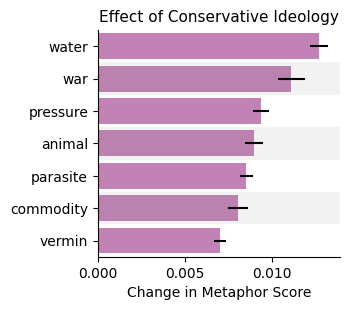

In [140]:
ESTIMATE = 'estimate'
ERROR = 'std.error'
plot_conservative_ideology_effect(df_mfx_id,ESTIMATE,ERROR,annot_bars=False,include_error=True,shading=True)
plt.xlabel("Change in Metaphor Score")
plt.savefig(os.path.join(plots_dir,f'conservative_{FRAME_PREFIX}_{ESTIMATE}.pdf'),bbox_inches='tight')

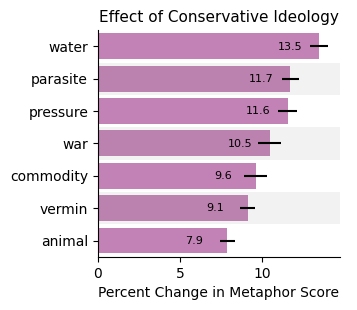

In [141]:
ESTIMATE = 'percent_change'
ERROR = 'percent_change_se'
plot_conservative_ideology_effect(df_mfx_id,ESTIMATE,ERROR,annot_bars=True,include_error=True,shading=True)
plt.xlabel("Percent Change in Metaphor Score")
plt.savefig(os.path.join(plots_dir,f'conservative_{FRAME_PREFIX}_{ESTIMATE}.pdf'),bbox_inches='tight')

In [142]:
def plot_ideology_strength_effect(df,estimate_col,error_col,include_error=True,shading=True):
    fig, ax = plt.subplots(figsize=(3,3))
    concept_order = df[df['ideology']=='Liberal'].sort_values(by=estimate_col,ascending=True)['concept'].tolist()
    sns.barplot(x=estimate_col,y='concept',hue='ideology',data=df,
                order=concept_order,legend=True,palette='colorblind',ax=ax)
    ax.legend(loc='upper center',bbox_to_anchor=(.85,1.03),fontsize=9,ncol=1)
    ax.axvline(0,color='black',alpha=.3)
    if include_error:
        err_pos = sorted([i - 0.2 for i in range(int(len(df)/2))] + [i+0.2 for i in range(int(len(df)/2))])
        errors = []
        estimates = []
        for concept in concept_order:
            errors += list(df.loc[(df['concept']==concept)].sort_values('ideology',ascending=False)[error_col])
            estimates += list(df.loc[(df['concept']==concept)].sort_values('ideology',ascending=False)[estimate_col])
        errors = [i*1.96 for i in errors]
    ax.errorbar(x = estimates,y=err_pos,xerr=errors,fmt = 'none',color='black')
    if shading:
        for i in range(1,7,2):
            ax.axhspan(i-.5,i+.5,facecolor='gray',alpha=0.1,clip_on=False)

    ax.set_ylim((6.5,-.5))
    #ax.set_xlabel("Percent Change in Metaphor Score")
    ax.set_ylabel("")
    ax.set_title("Effect of Ideology Strength",fontsize=11)
    sns.despine()
    return ax

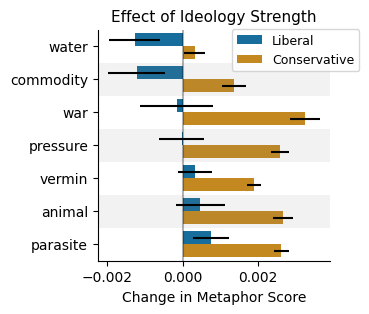

In [143]:
ESTIMATE = 'estimate'
ERROR = 'std.error'
plot_ideology_strength_effect(df_mfx_mag,ESTIMATE,ERROR,include_error=True,shading=True)
plt.xlabel('Change in Metaphor Score')
plt.savefig(os.path.join(plots_dir,f'strength_{FRAME_PREFIX}_{ESTIMATE}.pdf'),bbox_inches='tight')


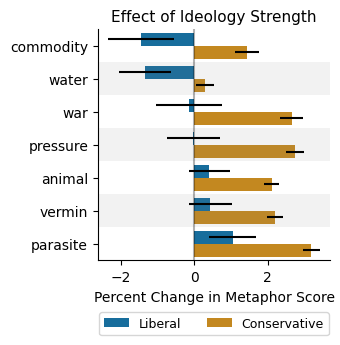

In [153]:
ESTIMATE = 'percent_change'
ERROR = 'percent_change_se'
plot_ideology_strength_effect(df_mfx_mag,ESTIMATE,ERROR,include_error=True,shading=True)
plt.xlabel('Percent Change in Metaphor Score')
plt.legend(loc='lower center',bbox_to_anchor=(0.5,-.35),fontsize=9,ncol=2)

plt.savefig(os.path.join(plots_dir,f'strength_{FRAME_PREFIX}_{ESTIMATE}.pdf'),bbox_inches='tight')


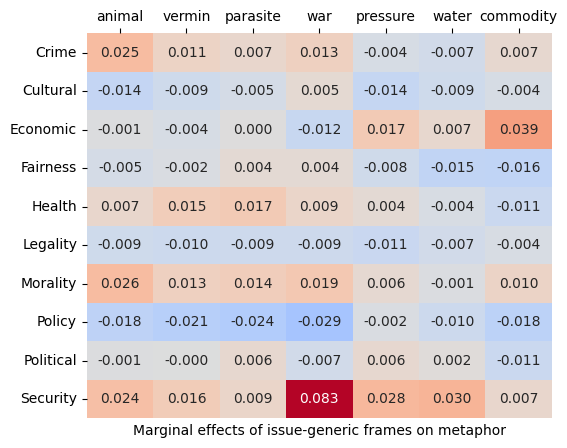

In [15]:
df_reg_sub = df_reg[['term','estimate','concept']]
df_reg_sub = df_reg_sub[df_reg_sub['term'].isin(frame_dict.values())]
df_reg_wide = df_reg_sub.pivot(columns='concept', index='term', values='estimate')
column_order = ['animal','vermin','parasite','war','pressure','water','commodity']
df_reg_wide = df_reg_wide[column_order]
df_reg_wide.index = df_reg_wide.index.str.replace('Security & Defense','Security')
df_reg_wide.index = df_reg_wide.index.str.replace('Political Factors','Political')
df_reg_wide.index = df_reg_wide.index.str.replace('Health & Safety','Health')
plt.figure(figsize = (6,5))
ax = sns.heatmap(df_reg_wide,cmap='coolwarm',center=0,annot=True,fmt='.3f',annot_kws={"fontsize":10},cbar=False)
ax.xaxis.tick_top()
#ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel("Marginal effects of issue-generic frames on metaphor",fontsize=10)
plt.ylabel('')
#plt.xticks(rotation=20)
plt.savefig(os.path.join(plots_dir,f'coefficients_by_frame_heatmap.pdf'),bbox_inches='tight')